# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.image as mpimg

if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
else:
    print("The installed version of TensorFlow does not include GPU support.")

The installed version of TensorFlow includes GPU support.


---
## Step 0: Load The Data

In [2]:
training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

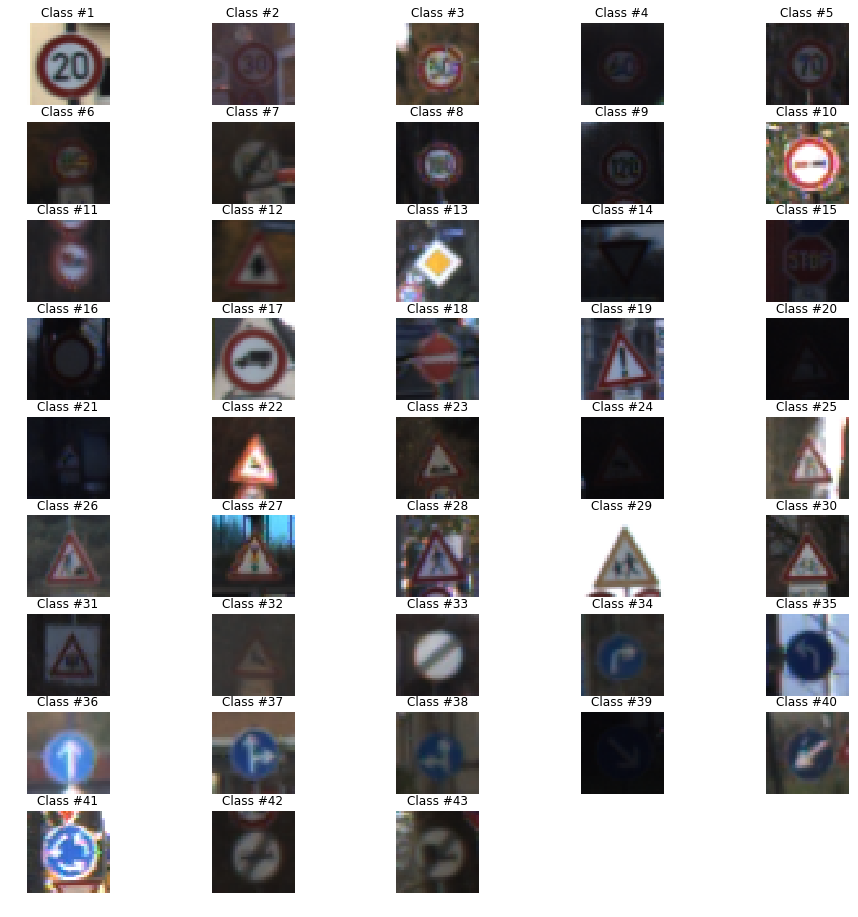

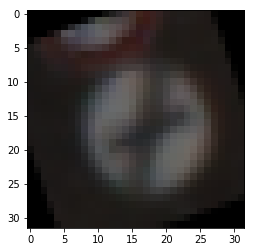

In [4]:
%matplotlib inline

# Save a representative image for each class
class_to_image_map = {}

# Visualize a candidate from each class in the training data
plt.figure(figsize=(16, 16))
for i in range(0, n_classes):
    plt.subplot(9, 5, i+1)
    first_img = next(img for img, train in zip(X_train, y_train) if train == i)
    plt.imshow(first_img)

    # Save off this one to represent the class for later
    class_to_image_map[i] = first_img
    
    plt.title('Class #{}'.format(i+1))
    plt.axis('off')
plt.show()
    

# Visualize a single rotation
im = X_train[0]
rows, cols, _ = im.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
dst = cv2.warpAffine(im,M,(cols,rows))

plt.figure()
plt.imshow(dst)



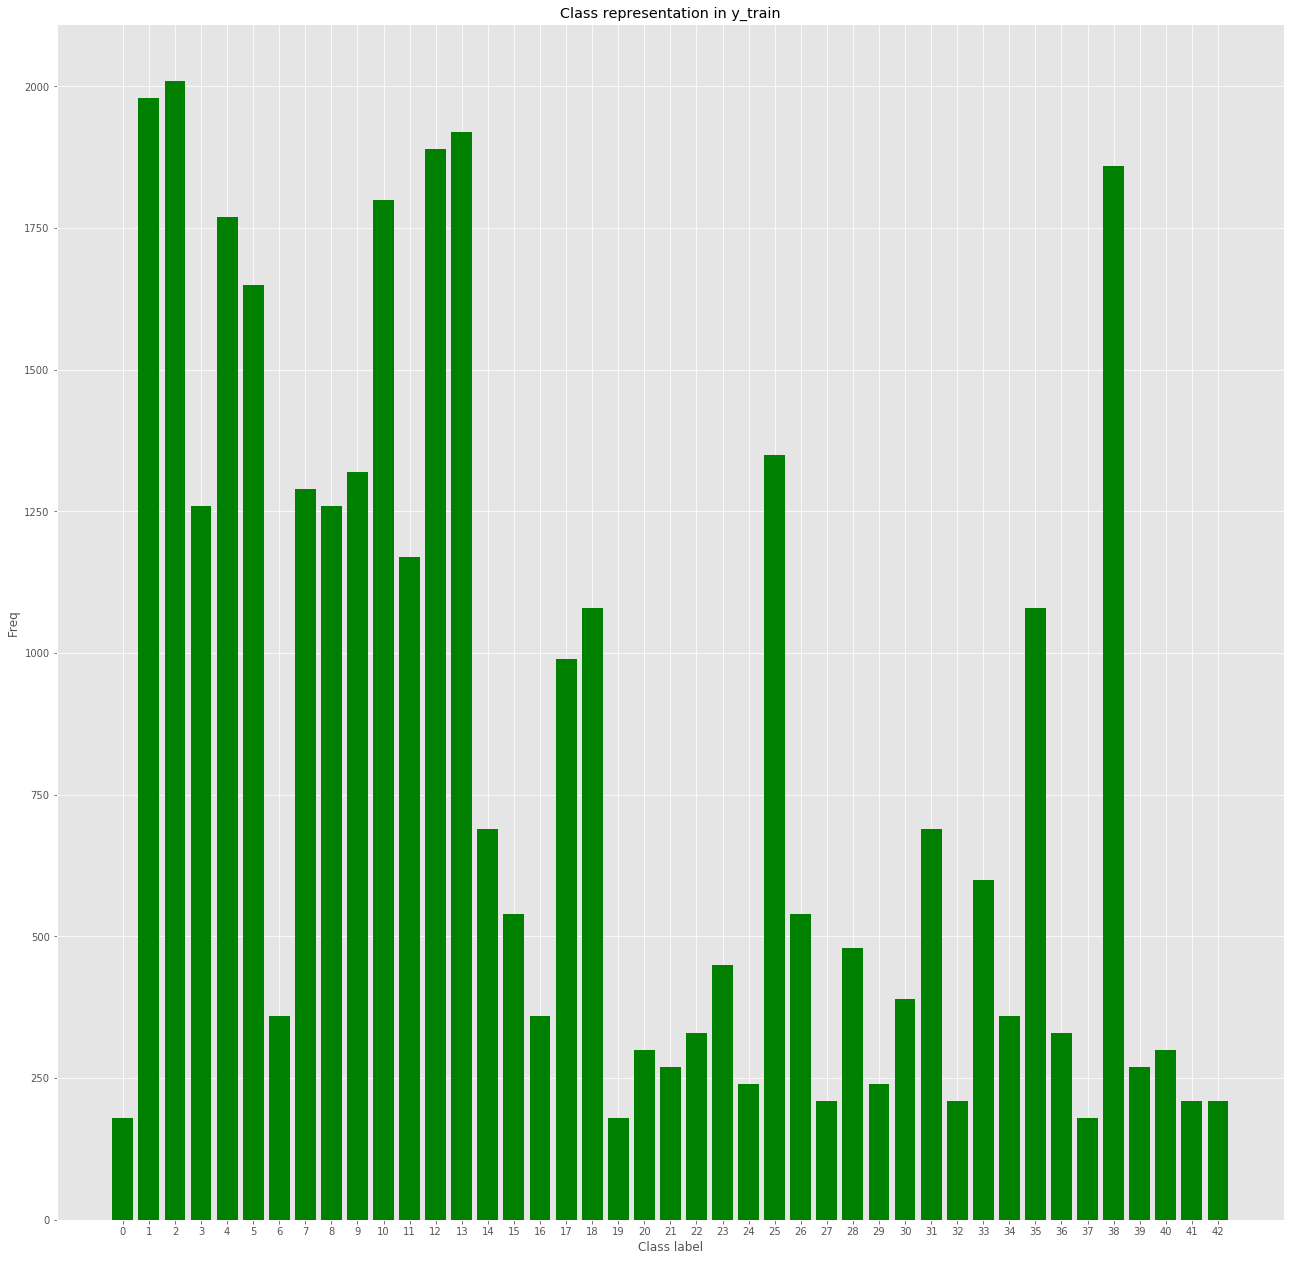

In [5]:
hist = [0 for _ in range(n_classes)]
for t in y_train:
    hist[t] += 1

%matplotlib inline
plt.figure(figsize=(22, 22))
plt.style.use('ggplot')

plt.bar(range(len(hist)), hist, color='green')
plt.xlabel("Class label")
plt.ylabel("Freq")
plt.title("Class representation in y_train")

plt.xticks(range(len(hist)), range(len(hist)))

plt.show()



## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [6]:
def rotations(imgs, degrees=20):
    """Returns a list of images with a rotation mapped over it.
    
    Args:
        imgs (list): A list of images.
        degrees (int): The # of degrees to perform a left rotation.
            Note: Subtract from 360 for right rotation.
        
    Returns:
        rotations (list): A list of transformed images"""
    # Double X_train with rotation for each training image
    rotations = []
    for x in X_train:
        rows, cols, _ = x.shape
        M = cv2.getRotationMatrix2D((cols/2,rows/2),degrees,1)
        rotations.append(cv2.warpAffine(im,M,(cols,rows)))
    
    return np.asarray(rotations)


def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

##################################################

rot_degree = 10

print('Size of X_train (original) = ', X_train.shape)
print('Size of y_train (original) = ', y_train.shape)

# Normalize images
X_train = ((X_train - 128.0) / 128.0) - 1
X_valid = ((X_valid - 128.0) / 128.0) - 1
X_test = ((X_test - 128.0) / 128.0) - 1


# TODO : Increase contrast

# TODO : Zoom in on images (lots of noise around edges)


# Apply rot_degree l and r rotations
l_rotated = rotations(X_train, degrees=rot_degree)
r_rotated = rotations(X_train, degrees=360-rot_degree)

X_train = np.concatenate((X_train, l_rotated))
X_train = np.concatenate((X_train, r_rotated))

# Triple y_train to match the 2 full sets of rotations plus originals
y1 = np.copy(y_train)
y2 = np.copy(y_train)
y_train = np.append(y_train,y1)
y_train = np.append(y_train, y2)

print('Size of X_train (after_rotations) = ', X_train.shape)
print('Size of y_train (after rotations) = ', y_train.shape)


Size of X_train (original) =  (34799, 32, 32, 3)
Size of y_train (original) =  (34799,)
Size of X_train (after_rotations) =  (104397, 32, 32, 3)
Size of y_train (after rotations) =  (104397,)


### Model Architecture

In [7]:
# Global hyperparams
mu = 0
sigma = 0.1

def conv_layer(x, kernel_dim, in_dim, out_dim):
    """A convolutional layer wrapper.
    
    Args:
        x: The input vector
        kernel_dim (int): The length of one side of a *square* kernel.
        in_dim: The depth of x.
        out_dim: The resulting depth of the convolution.
    """
    conv_W = tf.Variable(tf.truncated_normal(shape=(kernel_dim, kernel_dim, in_dim, out_dim),
                                             mean=mu, stddev=sigma))
    conv_b = tf.Variable(tf.zeros(out_dim))
    return tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b

def Net(x):
    """Convolutional neural net model."""
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x20.
    conv1 = conv_layer(x, 5, 3, 20)
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x20. Output = 14x14x36.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x36.
    conv2 = conv_layer(conv1, 5, 20, 36)
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x36. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x36. Output = 900.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 900. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(900, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)
    # But .. add dropout for this activation layer.
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation
    fc2    = tf.nn.relu(fc2)
    # But ... add dropout for this activation layer
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))    
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits



### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:

X_train, y_train = shuffle(X_train, y_train)

# Input images are 32x32 color
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None,))
# For dropout rate against fc2 fully-connected layer
keep_prob = tf.placeholder('float') # tf.float32)
one_hot_y = tf.one_hot(y, 43)

# Instantiate model
logits = Net(x)

rate = 0.0005  # Learning rate
EPOCHS = 17
BATCH_SIZE = 128

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# Original loss fcn
loss_operation = tf.reduce_mean(cross_entropy)
# L2 regularization of the loss function (actually not clear that this helped much)
regularizer = tf.nn.l2_loss(x)
loss_operation = tf.reduce_mean(loss_operation + 0.01 * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './model.ckpt')
    print("Model saved")

with tf.Session() as sess:
    # saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver.restore(sess, './model.ckpt')

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.365

EPOCH 2 ...
Validation Accuracy = 0.543

EPOCH 3 ...
Validation Accuracy = 0.719

EPOCH 4 ...
Validation Accuracy = 0.793

EPOCH 5 ...
Validation Accuracy = 0.822

EPOCH 6 ...
Validation Accuracy = 0.869

EPOCH 7 ...
Validation Accuracy = 0.882

EPOCH 8 ...
Validation Accuracy = 0.889

EPOCH 9 ...
Validation Accuracy = 0.903

EPOCH 10 ...
Validation Accuracy = 0.918

EPOCH 11 ...
Validation Accuracy = 0.911

EPOCH 12 ...
Validation Accuracy = 0.924

EPOCH 13 ...
Validation Accuracy = 0.895

EPOCH 14 ...
Validation Accuracy = 0.926

EPOCH 15 ...
Validation Accuracy = 0.937

EPOCH 16 ...
Validation Accuracy = 0.938

EPOCH 17 ...
Validation Accuracy = 0.944

Model saved
Test Accuracy = 0.931


---

## Step 3: Test a Model on New Images


### Load and Output the Images

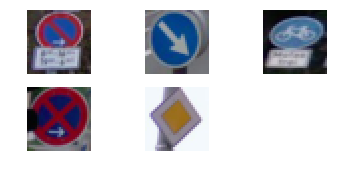

In [9]:
import matplotlib.image as mpimg
import scipy

images = []

for i in range(5):
    img = mpimg.imread('german_signs/streetview{}.jpg'.format(i+1))
    img = scipy.misc.imresize(img, (32, 32))
    images.append(img)

for i, img in enumerate(images):
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


The trained model believes that the following image:


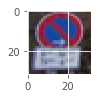

max class label probability: 0.8668612241744995
class label: 2
Which corresponds to the following representative image:


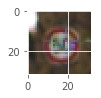

The trained model believes that the following image:


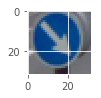

max class label probability: 0.8668612241744995
class label: 2
Which corresponds to the following representative image:


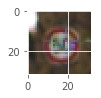

The trained model believes that the following image:


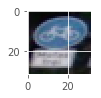

max class label probability: 0.8668612241744995
class label: 2
Which corresponds to the following representative image:


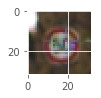

The trained model believes that the following image:


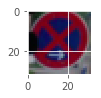

max class label probability: 0.8668612241744995
class label: 2
Which corresponds to the following representative image:


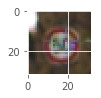

The trained model believes that the following image:


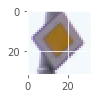

max class label probability: 0.8668612241744995
class label: 2
Which corresponds to the following representative image:


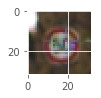

In [10]:
prediction=tf.argmax(logits,1)
import operator
prediction = logits

with tf.Session() as sess:
    # saver.restore(sess, tf.train.latest_checkpoint('./'))
    saver.restore(sess, './model.ckpt')
    for i in images:
        
        print('The trained model believes that the following image:')
        plt.subplot(3, 3, 3)
        plt.imshow(i)
        plt.show()

        pred = sess.run(prediction, feed_dict={x: [i], keep_prob: 1.0}) # , y: range(n_classes)
        
        index, value = max(enumerate(pred[0]), key=operator.itemgetter(1))

        print('max class label probability: {}'.format(value))
        print('class label: {}'.format(index))
        
        print('Which corresponds to the following representative image:')
        plt.subplot(3, 3, 3)
        plt.imshow(class_to_image_map[index])
        plt.show()
        print('=====================================================')

#print(images)
#print('---------------------------------------------------')

#with tf.Session() as sess:
#    saver.restore(sess, './model.ckpt')
#    pred = prediction.eval(feed_dict={x: images, keep_prob: 1.0}, session=sess)
#    print(pred)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.